In [5]:
#!pip install geopandas
#!pip install geopy
#!pip install pgeocode
#!pip install seaborn
#!pip install haversine

In [4]:
from setup import *
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# setup.file_pre_processing()

In [134]:
crime_data = pd.read_csv('crime_data_post_processing.csv', index_col=0)
hospitals = pd.read_csv('hospitals_data_post_processing.csv', index_col=0)

In [104]:
crime_data.head()

,county_name,crime_rate_per_100000,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,population,lat_long
0,"St. Louis city, MO",1791.995377,119,200,1778,3609,4995,13791,318416,"(29.6993748, -91.20677)"
1,"Crittenden County, AR",1754.914968,8,38,165,662,1482,1753,49746,"(35.2505701, -90.3192299)"
2,"Alexander County, IL",1664.700485,1,2,5,119,82,184,7629,"(37.1801529, -89.3502834)"
3,"Kenedy County, TX",1456.310680,0,3,1,2,5,4,412,"(27.221984, -97.79136)"
4,"De Soto Parish, LA",1447.402430,3,4,17,368,149,494,27083,"(31.901498, -93.670989)"


In [105]:
hospitals.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Same as the national average,Below the national average,Same as the national average,1108 ROSS CLARK CIRCLE DOTHAN AL 36301,"(31.216402000000002, -85.36564064472296)"
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Below the national average,Same as the national average,Same as the national average,2505 U S HIGHWAY 431 NORTH BOAZ AL 35957,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,Acute Care Hospitals,Government - Hospital District or Authority,Yes,2,Below the national average,Below the national average,Same as the national average,205 MARENGO STREET FLORENCE AL 35631,"(34.7946245, -87.68303582998244)"
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Same as the national average,Below the national average,702 N MAIN ST OPP AL 36467,"(31.2928787, -86.25490030241093)"
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Not Available,Same as the national average,101 HOSPITAL CIRCLE LUVERNE AL 36049,"(31.6937493, -86.26470160380265)"


In [135]:
#drop null lat long hosp. and crime
hospitals = hospitals[hospitals['lat_long'].notna()]
print(len(hospitals))



3928


In [136]:
crime_data = crime_data[crime_data['lat_long'] != "(Na,Na)"]
print(len(crime_data))

3130


In [137]:
import pgeocode
nomi = pgeocode.Nominatim('US')

In [138]:
#!pip install haversine
print(type(hospitals.loc[0]['lat_long']))

<class 'str'>


In [139]:

import ast
hospitals['lat_long'] = hospitals['lat_long'].apply(lambda x : ast.literal_eval(x))
crime_data['lat_long'] = crime_data['lat_long'].apply(lambda x : ast.literal_eval(x))

In [140]:
print(type(hospitals.loc[0]['lat_long']))

<class 'tuple'>


In [141]:
from haversine import haversine, Unit

def find_hospital_closest_county(hospital_lat_long):
    
    minimum = float('inf')
    index_of_minimum = 0
    for i, county_lat_long in enumerate(crime_data['lat_long'].tolist()):

        distance = haversine(hospital_lat_long, county_lat_long, unit=Unit.MILES)
        if distance < minimum:
            minimum = distance
            index_of_minimum = i
    
    return (crime_data.iloc[index_of_minimum]['county_name'], minimum)

In [142]:
# 18.2s: %timeit hospitals['county'], hospitals['distance_in_miles'] = zip(*hospitals['lat_long'].map(find_hospital_closest_county))
# 18.2s: %timeit hospitals['county'], hospitals['distance_in_miles'] = zip(*hospitals['lat_long'].apply(find_hospital_closest_county))
# 17.7s:
hospitals['county'], hospitals['distance_in_miles'] = zip(*hospitals['lat_long'].apply(lambda x : find_hospital_closest_county(x)))

In [143]:
hospitals['county']

0           Houston County, AL
2        Lauderdale County, AL
3         Covington County, AL
4          Crenshaw County, AL
5         Jefferson County, GA
                 ...          
4804    San Jacinto County, TX
4805          Worth County, MO
4806      Van Zandt County, TX
4807          Jones County, TX
4809     Assumption Parish, LA
Name: county, Length: 3928, dtype: object

In [144]:
hospitals['distance_in_miles']

0          8.140765
2          7.637646
3         13.809160
4          3.619856
5          9.474224
           ...     
4804      17.258489
4805       7.650199
4806      10.715789
4807       6.943816
4809    1324.743150
Name: distance_in_miles, Length: 3928, dtype: float64

In [145]:
len(hospitals)

3928

In [146]:
hospitals = hospitals.drop(hospitals[hospitals['distance_in_miles'] > 50].index)

In [147]:
len(hospitals)

3901

In [148]:
hospitals.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long,county,distance_in_miles
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Same as the national average,Below the national average,Same as the national average,1108 ROSS CLARK CIRCLE DOTHAN AL 36301,"(31.216402000000002, -85.36564064472296)","Houston County, AL",8.140765
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,Acute Care Hospitals,Government - Hospital District or Authority,Yes,2,Below the national average,Below the national average,Same as the national average,205 MARENGO STREET FLORENCE AL 35631,"(34.7946245, -87.68303582998244)","Lauderdale County, AL",7.637646
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Same as the national average,Below the national average,702 N MAIN ST OPP AL 36467,"(31.2928787, -86.25490030241093)","Covington County, AL",13.809160
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Not Available,Same as the national average,101 HOSPITAL CIRCLE LUVERNE AL 36049,"(31.6937493, -86.26470160380265)","Crenshaw County, AL",3.619856
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Below the national average,Below the national average,50 MEDICAL PARK EAST DRIVE BIRMINGHAM AL 35235,"(33.595315299999996, -86.66763066940506)","Jefferson County, GA",9.474224


## Elaina ->>

In [149]:
hospitals = hospitals[hospitals['Hospital overall rating']!='Not Available']
hospitals

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long,county,distance_in_miles
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Same as the national average,Below the national average,Same as the national average,1108 ROSS CLARK CIRCLE DOTHAN AL 36301,"(31.216402000000002, -85.36564064472296)","Houston County, AL",8.140765
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,Acute Care Hospitals,Government - Hospital District or Authority,Yes,2,Below the national average,Below the national average,Same as the national average,205 MARENGO STREET FLORENCE AL 35631,"(34.7946245, -87.68303582998244)","Lauderdale County, AL",7.637646
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Same as the national average,Below the national average,702 N MAIN ST OPP AL 36467,"(31.2928787, -86.25490030241093)","Covington County, AL",13.809160
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Not Available,Same as the national average,101 HOSPITAL CIRCLE LUVERNE AL 36049,"(31.6937493, -86.26470160380265)","Crenshaw County, AL",3.619856
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Below the national average,Below the national average,50 MEDICAL PARK EAST DRIVE BIRMINGHAM AL 35235,"(33.595315299999996, -86.66763066940506)","Jefferson County, GA",9.474224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,Acute Care Hospitals,Proprietary,Yes,4,Same as the national average,Above the national average,Same as the national average,850 W CENTRAL TEXAS EXPRESSWAY HARKER HEIGHTS ...,"(31.07255555, -97.68263831469964)","Coryell County, TX",25.371775
4780,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,Acute Care Hospitals,Voluntary non-profit - Private,Yes,4,Same as the national average,Above the national average,Same as the national average,5252 WEST UNIVERSITY DRIVE MC KINNEY TX 75071,"(33.2196077, -96.68214955013056)","Kinney County, TX",6.012212
4784,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,Acute Care Hospitals,Voluntary non-profit - Private,Yes,4,Same as the national average,Above the national average,Same as the national average,700 SCOTT & WHITE DRIVE COLLEGE STATION TX 77845,"(30.582118100000002, -96.27948966825502)","Burleson County, TX",24.886731
4787,670092,WALNUT HILL MEDICAL CENTER,7502 GREENVILLE AVENUE,DALLAS,TX,75231,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Below the national average,Same as the national average,7502 GREENVILLE AVENUE DALLAS TX 75231,"(32.8763542, -96.75192719885766)","Dawson County, TX",2.831800


In [150]:
hospitals['Hospital overall rating']=hospitals['Hospital overall rating'].astype(int)


In [151]:
hosp_grouped = hospitals.groupby('county')
hospital_mean_rating_by_county = hosp_grouped['Hospital overall rating'].mean()

In [153]:
#get countys with avg. rating of 5 and avg. rating of 1
top_rated_counties = hospital_mean_rating_by_county[hospital_mean_rating_by_county==5.0].index
top_rated_counties


Index(['Craven County, NC', 'Dubois County, IN', 'Emmet County, MI',
       'Gillespie County, TX', 'Houston County, GA', 'Jackson County, IN',
       'La Plata County, CO', 'Lincoln County, SD', 'Madison County, IA',
       'Morgan County, GA', 'Newport County, RI', 'Newton County, GA',
       'Winston County, AL'],
      dtype='object', name='county')

In [154]:
lowest_rated_counties = hospital_mean_rating_by_county[hospital_mean_rating_by_county==1.0].index

In [155]:
lowest_rated_counties

Index(['Banks County, GA', 'Bronx County, NY', 'Irwin County, GA',
       'Pittsylvania County, VA', 'Santa Cruz County, AZ', 'Sumner County, KS',
       'Sutter County, CA', 'York County, VA'],
      dtype='object', name='county')

In [156]:
crime_for_highest_rated=[]
counties_highest_rated=[]

for county in top_rated_counties:
    counties_highest_rated.append(county)
    crime_for_highest_rated.append(crime_data[crime_data['county_name']==county]['crime_rate_per_100000'].values[0])

In [157]:
crime_for_lowest_rated=[]
counties_lowest_rated=[]
for county in lowest_rated_counties:
    counties_lowest_rated.append(county)
    crime_for_lowest_rated.append(crime_data[crime_data['county_name']==county]['crime_rate_per_100000'].values[0])

In [158]:
avg_crime_for_lowest_rated = sum(crime_for_lowest_rated)/len(crime_for_lowest_rated)
avg_crime_for_highest_rated = sum(crime_for_highest_rated)/len(crime_for_highest_rated)

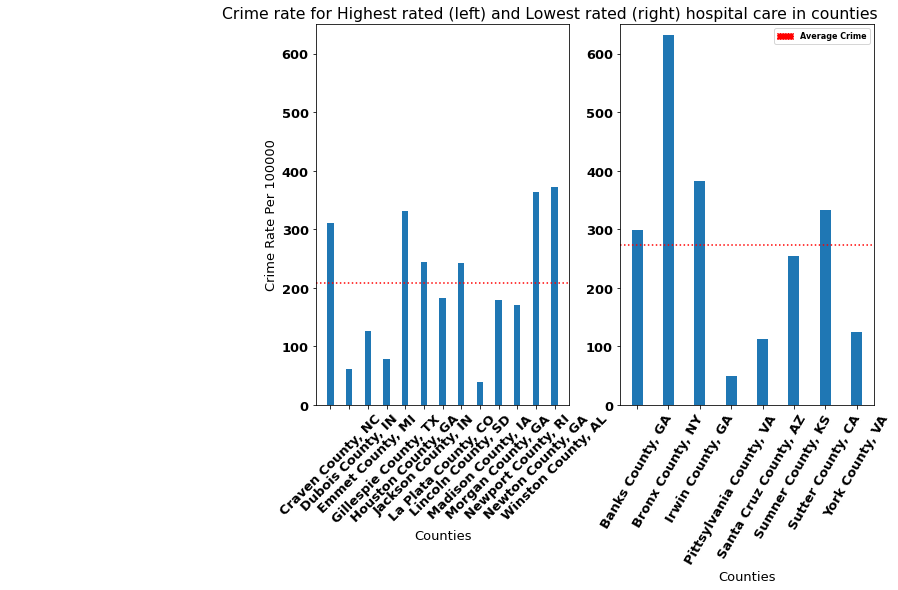

In [159]:
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

width = 0.35
font = {'size'   : '13','family' : 'DejaVu Sans','weight' : 'bold'}
plt.rc('font', **font)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(counties_highest_rated, crime_for_highest_rated, width)
ax1.set_ylabel('Crime Rate Per 100000')
ax1.set_xlabel('Counties')
ax1.tick_params(axis='x', rotation=45)
ax1.set_title('                                           Crime rate for Highest rated (left) and Lowest rated (right) hospital care in counties')
ax1.set_ylim([0, 650])
ax1.axhline(avg_crime_for_highest_rated, color='red', ls='dotted')




ax2.bar(counties_lowest_rated, crime_for_lowest_rated, width)
# ax2.set_ylabel('Crime Rate Per 100000')
ax2.set_xlabel('Counties')
ax2.tick_params(axis='x', rotation=60)
# ax2.set_title('Crime rate for Lowest rated hospital care in counties')
ax2.set_ylim([0, 650])
avg = ax2.axhline(avg_crime_for_lowest_rated, color='red', ls='dotted')
plt.rcParams['figure.figsize'] = [10, 7]
# plt.legend('avg')
font = {'size'   : '8','family' : 'DejaVu Sans'}
plt.rc('font', **font)
red_patch = mpatches.Patch(color='red', ls='dotted', label='Average Crime')
plt.legend(handles=[red_patch], loc='upper right')

plt.show()

# highest murder rate counties vs. Mortality national comparison


In [174]:
top_5_murder_counties = list(crime_data.sort_values(['MURDER'], ascending=False)[:5]['county_name'])


In [167]:
top_6_counties

['Los Angeles County, CA',
 'Cook County, IL',
 'Wayne County, MI',
 'Philadelphia County, PA',
 'Harris County, TX',
 'Baltimore city, MD']

In [162]:
dict_mortality_options = {
    'Not Available':-1,
    "Below the national average":0,
    "Same as the national average":1,
    "Above the national average":2
}
def Mortality_num_category(mortality_comparision):
    return dict_mortality_options[mortality_comparision]

hospitals['num_mortality_comparision'] = hospitals['Mortality national comparison'].map(dict_mortality_options)


In [163]:
hospitals_filtered = hospitals[hospitals['num_mortality_comparision']!=-1]

In [186]:
hosp_grouped = hospitals.groupby('county')['num_mortality_comparision'].mean()

def get_mortality_avg(county):
    return hosp_grouped[county]
values = crime_data.sort_values(['MURDER'], ascending=False)[:5]['county_name'].apply(get_mortality_avg)

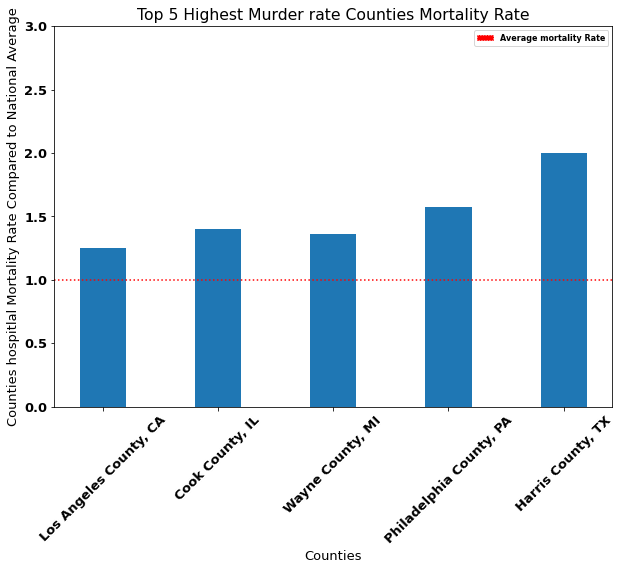

In [185]:
width = 0.4
font = {'size'   : '13','family' : 'DejaVu Sans','weight' : 'bold'}
plt.rc('font', **font)
fig,ax1 = plt.subplots(1)
ax1.bar(top_5_murder_counties, values, width)
ax1.set_ylabel('Avg. Mortality Rate in hospitals Compared to National Average')
ax1.set_xlabel('Counties')
ax1.tick_params(axis='x', rotation=45)
ax1.set_title('Top 5 Highest Murder rate Counties Mortality Rate')
ax1.set_ylim([0, 3])
font = {'size'   : '8','family' : 'DejaVu Sans'}
plt.rc('font', **font)
avg = ax1.axhline(1, color='red', ls='dotted')
red_patch = mpatches.Patch(color='red', ls='dotted', label='Average mortality Rate')
plt.legend(handles=[red_patch], loc='upper right')


plt.show()


## Adam ->>

In [37]:
hospitals = hospitals.rename({'county':'county_name'}, axis=1)

In [38]:
hospitals.head(1)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long,county_name,distance_in_miles
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Same as the national average,Below the national average,Same as the national average,1108 ROSS CLARK CIRCLE DOTHAN AL 36301,"(31.216402000000002, -85.36564064472296)","Houston County, AL",8.140765


In [39]:
crime_data.head(1)

,county_name,crime_rate_per_100000,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,population,lat_long
0,"St. Louis city, MO",1791.995377,119,200,1778,3609,4995,13791,318416,"(29.6993748, -91.20677)"


In [43]:
hospitals_merged = hospitals.\
merge(crime_data, on='county_name', how='left').drop(['full_address', 'lat_long_x', 'lat_long_y'], axis=1)

In [51]:
hospitals_merged.head(1)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,...,county_name,distance_in_miles,crime_rate_per_100000,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,population
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,...,"Houston County, AL",8.140765,401.281012,7,42,108,259,1095,2380,103668


In [75]:
hospitals_merged.columns

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'Hospital Type', 'Hospital Ownership', 'Emergency Services',
       'Hospital overall rating', 'Mortality national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison', 'county_name',
       'distance_in_miles', 'crime_rate_per_100000', 'MURDER', 'RAPE',
       'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 'population', 'pop_bin'],
      dtype='object')

### Density of distances from hospital to nearest county. ~2/3 are within the county

<AxesSubplot:ylabel='Density'>

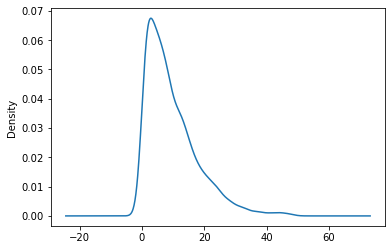

In [52]:
hospitals_merged.distance_in_miles.plot.density()

In [53]:
hospitals_merged.county_name.value_counts()

Los Angeles County, CA       69
Granite County, MT           27
Orange County, CA            21
San Bernardino County, CA    18
Orange County, VA            18
                             ..
Jeff Davis County, TX         1
Mecosta County, MI            1
Hale County, TX               1
Smith County, MS              1
Geneva County, AL             1
Name: county_name, Length: 2030, dtype: int64

In [57]:
hospitals_merged.population.mean()

448931.4719302743

In [58]:
hospitals_merged.population.std()

1419338.6763189603

In [62]:
hospitals_merged['pop_bin'] = pd.qcut(hospitals_merged['population'], 10)

In [63]:
hospitals_merged['pop_bin']

0       (88457.0, 161451.0]
1       (88457.0, 161451.0]
2        (34689.0, 51577.0]
3        (13898.0, 21893.0]
4        (13898.0, 21893.0]
               ...         
3896     (13898.0, 21893.0]
3897     (21893.0, 34689.0]
3898       (89.999, 7828.0]
3899     (51577.0, 88457.0]
3900     (13898.0, 21893.0]
Name: pop_bin, Length: 3901, dtype: category
Categories (10, interval[float64]): [(89.999, 7828.0] < (7828.0, 13898.0] < (13898.0, 21893.0] < (21893.0, 34689.0] ... (88457.0, 161451.0] < (161451.0, 361220.0] < (361220.0, 919866.0] < (919866.0, 10017068.0]]

In [74]:
no_unrated_hospitals = hospitals_merged[hospitals_merged['Hospital overall rating'] != 'Not Available']
no_unrated_hospitals['Hospital overall rating'] = pd.to_numeric(no_unrated_hospitals['Hospital overall rating'])
no_unrated_hospitals.groupby('pop_bin')['crime_rate_per_100000'].mean()

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


pop_bin
(89.999, 7828.0]          118.500547
(7828.0, 13898.0]         181.498182
(13898.0, 21893.0]        217.596108
(21893.0, 34689.0]        231.912831
(34689.0, 51577.0]        236.672266
(51577.0, 88457.0]        250.904169
(88457.0, 161451.0]       276.337083
(161451.0, 361220.0]      339.359648
(361220.0, 919866.0]      473.596985
(919866.0, 10017068.0]    498.267222
Name: crime_rate_per_100000, dtype: float64

Provider ID                                     int64
Hospital Name                                  object
Address                                        object
City                                           object
State                                          object
ZIP Code                                        int64
Hospital Type                                  object
Hospital Ownership                             object
Emergency Services                             object
Hospital overall rating                        object
Mortality national comparison                  object
Patient experience national comparison         object
Effectiveness of care national comparison      object
county_name                                    object
distance_in_miles                             float64
crime_rate_per_100000                         float64
MURDER                                          int64
RAPE                                            int64
ROBBERY                     

In [68]:
type(hospitals_merged['Hospital overall rating'].iloc[0])

str

In [77]:
hospitals_merged['Hospital Ownership'].value_counts()

Voluntary non-profit - Private                 1677
Proprietary                                     628
Government - Hospital District or Authority     473
Voluntary non-profit - Other                    379
Government - Local                              325
Voluntary non-profit - Church                   295
Physician                                        55
Government - State                               45
Government - Federal                             20
Tribal                                            4
Name: Hospital Ownership, dtype: int64

The analysis of the 2000 UCR crime data for the 1,294 cities with populations over 25,000 revealed a significant positive relationship between crime rate and population size, indicating that the higher populated cities reported the higher crime rates.

(Nolan, James J., 'Establishing the statistical relationship between population size and UCR crime rate: Its impact and implications', Journal of Criminal Justice
Volume 32, Issue 6, November–December 2004, Pages 547-555, https://www.sciencedirect.com/science/article/pii/S0047235204000832)

So there is evidence to show that higher populated areas reported higher crime rates, which is evidenced in our data by grouping counties by population size and examining crime rates:

In [78]:
no_unrated_hospitals = hospitals_merged[hospitals_merged['Hospital overall rating'] != 'Not Available']
no_unrated_hospitals['Hospital overall rating'] = pd.to_numeric(no_unrated_hospitals['Hospital overall rating'])
no_unrated_hospitals.groupby('pop_bin')['crime_rate_per_100000'].mean()

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


pop_bin
(89.999, 7828.0]          118.500547
(7828.0, 13898.0]         181.498182
(13898.0, 21893.0]        217.596108
(21893.0, 34689.0]        231.912831
(34689.0, 51577.0]        236.672266
(51577.0, 88457.0]        250.904169
(88457.0, 161451.0]       276.337083
(161451.0, 361220.0]      339.359648
(361220.0, 919866.0]      473.596985
(919866.0, 10017068.0]    498.267222
Name: crime_rate_per_100000, dtype: float64

It seems our data supports this conclusion. But what can county populations tell us about the quality of hospitals? Does crime play a part in the quality of hospitals?

In [83]:
no_unrated_hospitals.groupby('pop_bin')['Hospital overall rating'].mean()

pop_bin
(89.999, 7828.0]          3.125683
(7828.0, 13898.0]         3.096154
(13898.0, 21893.0]        3.212838
(21893.0, 34689.0]        3.193651
(34689.0, 51577.0]        3.147910
(51577.0, 88457.0]        3.115854
(88457.0, 161451.0]       3.143750
(161451.0, 361220.0]      3.020349
(361220.0, 919866.0]      3.000000
(919866.0, 10017068.0]    2.786787
Name: Hospital overall rating, dtype: float64

It would seem that there is not an enormously noticeable difference between different county populations and hospital ratings, though the counties with the largest populations did, on average, seem to have the lowest  hospital ratings. Perhaps we can look to try and find some kind of relationship between crime rates and other crime metrics versus the quality of hospitals.

In [181]:
hospital_rating_vs_crime = no_unrated_hospitals.groupby('Hospital overall rating')['crime_rate_per_100000'].mean()

In [182]:
x = hospital_rating_vs_crime.index
y = hospital_rating_vs_crime.values

([<matplotlib.axis.XTick at 0x7fe1e4f29b38>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

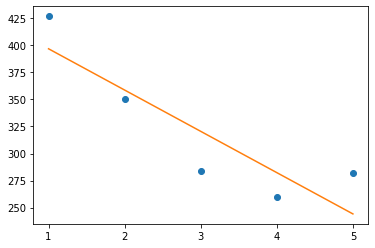

In [184]:
import numpy as np
from sklearn.linear_model import LinearRegression
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.xticks([1, 2, 3, 4, 5])

In [110]:
x_as_np = np.array(x).reshape((-1, 1))
y_as_np = np.array(y)

In [111]:
model = LinearRegression().fit(x_as_np, y_as_np)
r_sq = model.score(x_as_np, y_as_np)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7748650630657178


In [ ]:
hospital_rating_vs_crime = no_unrated_hospitals.groupby('Hospital overall rating')['crime_rate_per_100000'].mean()

In [185]:
no_unrated_hospitals['crime_rate_bin'] = pd.qcut(no_unrated_hospitals['crime_rate_per_100000'], 10)

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [186]:
crime_vs_hospital_rating = no_unrated_hospitals.groupby('crime_rate_bin')['Hospital overall rating'].mean()

In [187]:
crime_vs_hospital_rating

crime_rate_bin
(-0.001, 63.709]       3.203333
(63.709, 108.947]      3.256667
(108.947, 150.425]     3.120000
(150.425, 192.612]     3.243333
(192.612, 239.653]     3.123333
(239.653, 298.366]     3.120000
(298.366, 374.904]     2.990066
(374.904, 444.801]     2.971609
(444.801, 583.327]     2.946996
(583.327, 1791.995]    2.815436
Name: Hospital overall rating, dtype: float64

In [188]:
x = crime_vs_hospital_rating.index
y = crime_vs_hospital_rating.values

In [189]:
x = x.astype(str)

In [190]:
idex = np.asarray([i+1 for i in range(len(x))])
idex

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

([<matplotlib.axis.YTick at 0x7fe1e58e9fd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

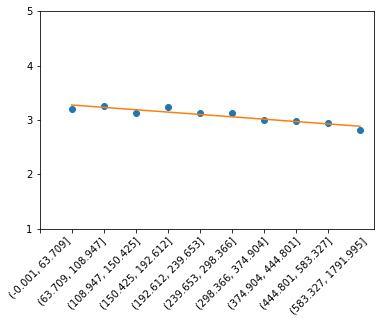

In [192]:
plt.plot(idex, y, 'o')
m, b = np.polyfit(idex, y, 1)
plt.plot(idex, m*idex+b)
plt.xticks(idex)
plt.xticks(np.arange(10), x,
       rotation=45)  # Set text labels and properties.
plt.yticks([1, 2, 3, 4, 5])

([<matplotlib.axis.YTick at 0x7fe1e5942cf8>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

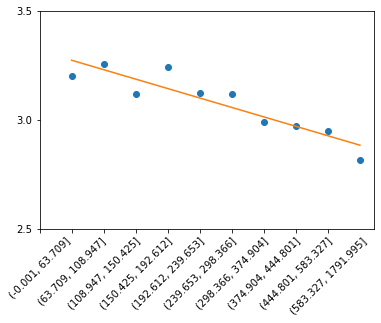

In [193]:
plt.plot(idex, y, 'o')
m, b = np.polyfit(idex, y, 1)
plt.plot(idex, m*idex+b)
plt.xticks(idex)
plt.xticks(np.arange(10), x,
       rotation=45)  # Set text labels and properties.
plt.yticks([2.5, 3, 3.5])

In [194]:
x_as_np = np.array(idex).reshape((-1, 1))
y_as_np = np.array(y)

In [195]:
model = LinearRegression().fit(x_as_np, y_as_np)
r_sq = model.score(x_as_np, y_as_np)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8375126921639457


The R-Squared coefficient of determination measures the proportion of variation in the dependent variable that can be attributed to the independent variable. In this instance, ~83% of the variation in hospital rating seemingly can be attributed to crime rates. But this is misleading: we already know crime rates increase with population size and that hospital rating decreases with increasing population size, so it could be possible that population size is a confounding variable which makes it hard to verify that hospital rating and crime rates are directly related.

What if we tried to control for population size?

In [523]:
no_unrated_hospitals['pop_bin'] = pd.qcut(no_unrated_hospitals['population'], 20)
no_unrated_hospitals['pop_bin']

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        (81174.0, 110079.2]
1        (81174.0, 110079.2]
2         (34689.0, 41665.2]
3         (10790.5, 14055.9]
4         (14055.9, 17713.0]
                ...         
3883      (63620.0, 81174.0]
3884        (94.999, 6401.8]
3887      (14055.9, 17713.0]
3889      (10790.5, 14055.9]
3892    (147590.4, 194020.0]
Name: pop_bin, Length: 3000, dtype: category
Categories (20, interval[float64]): [(94.999, 6401.8] < (6401.8, 10790.5] < (10790.5, 14055.9] < (14055.9, 17713.0] ... (413632.6, 687802.0] < (687802.0, 970264.7] < (970264.7, 2088371.0] < (2088371.0, 10017068.0]]

In [524]:
import scipy.stats as st

In [526]:
def confidence_interval(sample):
    if type(sample) != list:
        return np.nan
    elif len(sample) < 5:
        return np.nan
    elif len(sample) < 30:
        return st.t.interval(alpha=0.95, df=len(sample)-1, loc=np.mean(sample), scale=st.sem(sample))
    else:
        return st.norm.interval(alpha=0.95, loc=np.mean(sample), scale=st.sem(sample))

In [527]:
no_unrated_hospitals['crime_rate_per_100000']

0       401.281012
1       262.939535
2       258.670749
3       479.050479
4       306.372549
           ...    
3883    185.058799
3884      0.000000
3887    139.786825
3889    188.269370
3892    201.674753
Name: crime_rate_per_100000, Length: 3000, dtype: float64

In [529]:
grouped_by_pop_and_hospital_rating = \
no_unrated_hospitals.groupby(['pop_bin', 'Hospital overall rating']) \
['crime_rate_per_100000'].agg(lambda x : confidence_interval(x.tolist()))

In [530]:
grouped_by_pop_and_hospital_rating

pop_bin                  Hospital overall rating
(94.999, 6401.8]         1                                                               NaN
                         2                           (50.95317049937865, 141.49972278157372)
                         3                           (62.93855022622761, 118.73775952351599)
                         4                           (61.95672024534626, 134.48543491365376)
                         5                           (27.75232376828552, 170.60293931171447)
                                                                      ...                   
(2088371.0, 10017068.0]  1                            (490.8451768447728, 670.4010799734087)
                         2                          (402.36264273946256, 486.59780378275957)
                         3                           (436.73456020708227, 498.9681587595842)
                         4                            (386.3216316450688, 467.0192442652759)
                     

In [531]:
grouped_by_pop_and_hospital_rating

pop_bin                  Hospital overall rating
(94.999, 6401.8]         1                                                               NaN
                         2                           (50.95317049937865, 141.49972278157372)
                         3                           (62.93855022622761, 118.73775952351599)
                         4                           (61.95672024534626, 134.48543491365376)
                         5                           (27.75232376828552, 170.60293931171447)
                                                                      ...                   
(2088371.0, 10017068.0]  1                            (490.8451768447728, 670.4010799734087)
                         2                          (402.36264273946256, 486.59780378275957)
                         3                           (436.73456020708227, 498.9681587595842)
                         4                            (386.3216316450688, 467.0192442652759)
                     

In [532]:
no_unrated_hospitals.groupby(['pop_bin', 'Hospital overall rating']) \
['crime_rate_per_100000'].count()

pop_bin                  Hospital overall rating
(94.999, 6401.8]         1                           4
                         2                          21
                         3                          78
                         4                          40
                         5                           7
                                                    ..
(2088371.0, 10017068.0]  1                          11
                         2                          36
                         3                          60
                         4                          29
                         5                           2
Name: crime_rate_per_100000, Length: 100, dtype: int64

In [537]:
grouped_by_pop_and_hospital_rating = \
no_unrated_hospitals.groupby(['pop_bin', 'Hospital overall rating']) \
['crime_rate_per_100000'].agg('mean').unstack(level=0)

In [538]:
df = grouped_by_pop_and_hospital_rating.copy()
df

pop_bin,"(94.999, 6401.8]","(6401.8, 10790.5]","(10790.5, 14055.9]","(14055.9, 17713.0]","(17713.0, 22449.25]","(22449.25, 27887.2]","(27887.2, 34689.0]","(34689.0, 41665.2]","(41665.2, 49873.2]","(49873.2, 63620.0]","(63620.0, 81174.0]","(81174.0, 110079.2]","(110079.2, 147590.4]","(147590.4, 194020.0]","(194020.0, 270937.0]","(270937.0, 413632.6]","(413632.6, 687802.0]","(687802.0, 970264.7]","(970264.7, 2088371.0]","(2088371.0, 10017068.0]"
Hospital overall rating,,,,,,,,,,,,,,,,,,,,
1,102.599179,156.376392,71.556351,230.205367,187.123303,254.334280,NaN,NaN,182.032159,180.907640,167.157580,387.974854,206.134140,230.438358,363.291500,585.783354,850.080680,569.348735,618.439233,580.623128
2,96.226447,191.926925,158.057816,206.442535,301.922419,403.756885,251.978560,315.975128,249.919965,284.277816,335.366917,263.379617,275.911174,326.404943,363.765486,415.813923,500.958664,553.980471,484.009921,444.480223
3,90.838155,193.092094,211.870314,169.387297,261.431114,262.484424,214.250684,269.087879,235.676633,265.894046,264.790707,280.792058,279.730371,272.589562,352.077342,431.329916,411.478919,505.446774,469.484938,467.851359
4,98.221078,147.588230,198.660120,195.187698,216.289231,193.155618,169.721641,171.637743,192.221920,183.868174,229.824954,237.137806,234.031829,293.299067,304.899770,345.191006,449.052650,576.893348,515.145335,426.670438
5,99.177632,99.488575,203.166361,38.839979,272.000899,225.803114,210.678271,NaN,232.166351,188.130273,NaN,232.313638,344.543816,410.009157,443.602085,378.273035,395.532454,559.056971,396.610574,537.598508


In [539]:
for column in grouped_by_pop_and_hospital_rating.columns:
    df[column] = (df[column]-df[column].mean())/df[column].std()

In [543]:
df

pop_bin,"(94.999, 6401.8]","(6401.8, 10790.5]","(10790.5, 14055.9]","(14055.9, 17713.0]","(17713.0, 22449.25]","(22449.25, 27887.2]","(27887.2, 34689.0]","(34689.0, 41665.2]","(41665.2, 49873.2]","(49873.2, 63620.0]","(63620.0, 81174.0]","(81174.0, 110079.2]","(110079.2, 147590.4]","(147590.4, 194020.0]","(194020.0, 270937.0]","(270937.0, 413632.6]","(413632.6, 687802.0]","(687802.0, 970264.7]","(970264.7, 2088371.0]","(2088371.0, 10017068.0]"
Hospital overall rating,,,,,,,,,,,,,,,,,,,,
1,1.195425,-0.034271,-1.671548,0.824293,-1.325006,-0.168252,NaN,NaN,-1.231436,-0.790789,-1.170302,1.699733,-1.178916,-1.127711,-0.044804,1.667732,1.746757,0.585734,1.507194,1.366288
2,-0.273361,0.890083,-0.182540,0.509344,1.183806,1.684063,1.199116,0.865701,1.067069,1.267842,1.226652,-0.267460,0.149247,0.294215,-0.035305,-0.166922,-0.108751,0.036965,-0.157629,-0.719536
3,-1.515253,0.920378,0.743770,0.018220,0.298912,-0.067219,0.077125,0.228905,0.584827,0.901727,0.220953,0.007460,0.221943,-0.503162,-0.269532,0.000558,-0.584317,-1.696073,-0.337512,-0.361470
4,0.186361,-0.262773,0.516375,0.360174,-0.687616,-0.926653,-1.247126,-1.094607,-0.886437,-0.731830,-0.277303,-0.681783,-0.647901,-0.196311,-1.214959,-0.929228,-0.384620,0.855137,0.227963,-0.992397
5,0.406828,-1.513417,0.593943,-1.712032,0.529903,-0.521939,-0.029115,NaN,0.465978,-0.646949,NaN,-0.757950,1.455627,1.532969,1.564600,-0.572139,-0.669069,0.218237,-1.240016,0.707115


In [544]:
count_where_higher_quality_hospital_and_crime_reduced = 0
count_where_higher_quality_hospital_and_crime_increased = 0
higher_quality_hospital_and_crime_reduced_std = 0
higher_quality_hospital_and_crime_increased_std = 0
for column in df.columns:
    this_column_values = df[column].values
    if pd.isnull(this_column_values[1]) or pd.isnull(this_column_values[3]):
        pass
    else: 
        if this_column_values[3] < this_column_values[1]:
            higher_quality_hospital_and_crime_reduced_std += this_column_values[3] - this_column_values[1]
            count_where_higher_quality_hospital_and_crime_reduced += 1
        else:
            higher_quality_hospital_and_crime_increased_std += this_column_values[1] - this_column_values[3]
            count_where_higher_quality_hospital_and_crime_increased += 1
            
print(f'# of instances where crime DECREASED as hospital quality increased: {count_where_higher_quality_hospital_and_crime_reduced}')
print(f'# of instances where crime INCREASED as hospital quality increased: {count_where_higher_quality_hospital_and_crime_increased}')
print(f'\nAvg # of standard deviations of REDUCTION in crime as hospital quality increased: {-higher_quality_hospital_and_crime_reduced_std/count_where_higher_quality_hospital_and_crime_reduced}')
print(f'Avg # of standard deviations of INCREASE in crime as hospital quality increased: {-higher_quality_hospital_and_crime_increased_std/count_where_higher_quality_hospital_and_crime_increased}')

# of instances where crime DECREASED as hospital quality increased: 16
# of instances where crime INCREASED as hospital quality increased: 4

Avg # of standard deviations of REDUCTION in crime as hospital quality increased: 1.2400332967827434
Avg # of standard deviations of INCREASE in crime as hospital quality increased: 0.5906002654504938


In [552]:
grouped_by_pop_and_hospital_rating = \
no_unrated_hospitals.groupby(['pop_bin', 'Hospital overall rating']) \
['crime_rate_per_100000'].agg('mean').unstack(level=0)

In [557]:
from math import sqrt

([<matplotlib.axis.XTick at 0x7fe1e755bcc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

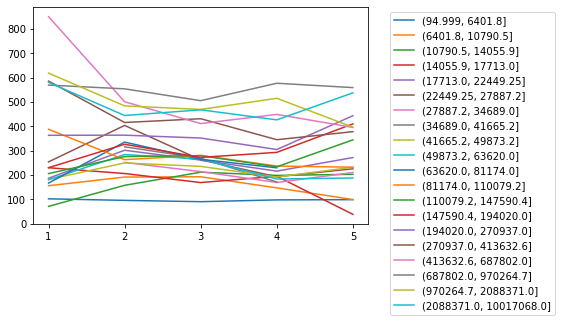

In [559]:
plt.plot(grouped_by_pop_and_hospital_rating)
plt.legend(grouped_by_pop_and_hospital_rating.columns, bbox_to_anchor=(1.05, 1))
plt.xticks([1, 2, 3, 4, 5])

It seems population does seem to play a significant role in crime rates. The larger population bins saw higher crime rates (a relationship previously shown), but also saw greater reductions in crime as hospital quality increased. This was evident in the fact that the two largest population county bins (each bin had an equal number of counties) saw the greatest reduction in crime rates as hospital quality increased. 4/10 (5/10 if accounting for the N/A, which generally saw a decline) bins which demonstrated a reduction in crime rates as hospital quality increased saw a greater average standard deviation of reduction (1.86 st devs) in comparison to the 5/10 bins which saw an increase in crime rates as hospital quality increased (1.02 st devs). So, we are able to conclude that population is a factor in determining the crime rate of a county. Intuitively, because of the positive relationship between population and crime and the negative relationship between population and hospital rating, hospital rating and crime should also have a negative relationship. Though without more data (especially on hospitals rated 1 or 5) it is difficult to discern exactly how impactful hospital quality

^ different conclusion based on more data!!

## Problem Statement
My goal with this notebook is to use to answer the question: *is class positively correlated with survival on the ship Titanic?*

## Data

To answer this question I will use a dataset from Kaggle called titanic 
(link here: [titanic dataset](https://www.kaggle.com/c/titanic)). I collected this by downloading the csv. The data is stored in a csv format. There are 891 rows and 12 columns. The total size of the file is 59 kB. 

## Data cleaning and manipulation

To address my central question I did the following data cleaning steps:
    ....
    
This are all contained in the file data_cleaning_functions.py. 

## Analysis

To present my analysis I first consider a table of survival rates for each class. Here I can see that the proportion of passengers in the first class who survived is much higher than for the second and third classes. 

However, it is possible that this gap is not trustworthy if there is very little data in one of these classes. So I will also plot survival and include the size of the category in the plot. 

In the plot although we can see there is more data in the third class the amount of data in the first class is not so small that I am concerned. I do think there is a statistically valid relationship between class and survival. However, to be triple sure, I'll check the correlation coefficient between plcass and survival rate and check that it is statistically significant. 

Surprisingly, although the correlation coefficient is very strong negative, it is not statistically signifanct (probably because I only have three values and have lost all information about the size of the data). 


Now I see a weaker but much more significant relationship between the two variables. However, it the pearson correlation coefficient isn't really set up for this kind of comparison, so in future work I will use a better measure. 

## Take-aways
For now, I am convinced that as class goes up from 3 -> 1 there is an increase in survival rates. While the relationship is strong and seems to be significant, I will test the significant levels more thoroughly in future work.  

## References 

Include all references to sources for the code, sources for any packages or methods you used and a guide to all of the files you wrote and are including. 